# Checking and manually adjustmenting analysis regions for XXL-100-GC

This notebook will allow us to go through combined images (i.e. all available data for each cluster) and inspect the source regions that are being used to remove contaminant emission. As XXL is a shallow survey there may also be cases where clusters are broken into various regions so some may need moving or removing. Then we can choose whether or not to adjust the regions, and if so we can save those changes to new custom region files that will be inserted into the XGA analysis.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
import matplotlib.pyplot as plt
%matplotlib widget
from typing import Union, List
from shutil import rmtree
import os

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xxlgc100_colour, xxl_cosmo

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix

import warnings
warnings.filterwarnings('ignore')

## Declaring XGA ClusterSample for XXL-100-GC

In [2]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 14/14 [00:51<00:00,  3.71s/it]


## Setting up region storage directories

This just sets up the storage structure for the output region files.

In [4]:
if not os.path.exists('../../outputs/custom_regions/xxl'):
    os.makedirs('../../outputs/custom_regions/xxl')

for src in xxl_srcs:
    sp_pth = '../../outputs/custom_regions/xxl/{n}'.format(n=src.name)
    if not os.path.exists(sp_pth):
        os.makedirs(sp_pth)

## Region checking and adjustment

This part of the notebook allows us to directly interact with images and their regions - therefore modifications can be made to the source regions, or new regions added, to properly remove contaminating emission that might bias our analyses.

In [5]:
plt.close('all')

XLSSC-511


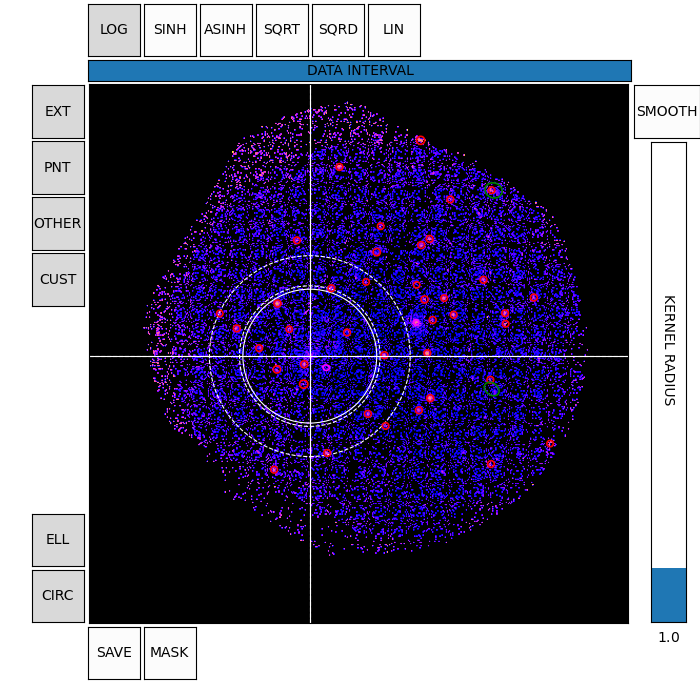

In [18]:
src = xxl_srcs[13]
print(src.name)

crt = src.get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
crt.image.regions = src.get_interloper_regions(flattened=False)
crt.regions = src.get_interloper_regions(flattened=False)
save_path = "../../outputs/custom_regions/xxl/{n}/mod_{n}.reg".format(n=src.name)

analysis_radius = src.r500*1.2
pix_analysis = physical_rad_to_pix(crt, analysis_radius, src.peak, src.redshift, src.cosmo)
pix_inn_back = physical_rad_to_pix(crt, analysis_radius*1.05, src.peak, src.redshift, src.cosmo)
pix_out_back = physical_rad_to_pix(crt, analysis_radius*1.5, src.peak, src.redshift, src.cosmo)

an_rad = Quantity([0, pix_analysis.value], 'pix')
bck_rad = Quantity([pix_inn_back, pix_out_back])

ch = Quantity([src.peak, src.ra_dec])
# ch = src.peak

# crt.image.edit_regions(reg_save_path=save_path, cross_hair=ch, radial_bins_pix=an_rad, back_bin_pix=bck_rad)
crt.edit_regions(reg_save_path=save_path, cross_hair=ch, radial_bins_pix=an_rad, back_bin_pix=bck_rad)

## Notes

* XLSSC-54 must be very low redshift or something because the $R_{500}$ region is massive
* XLSSC-11 Ditto
* XLSSC-533 has a weird hole in the data, pre-masking
* XLSSC-505 has a massive $R_{500}$ region